# Data exploration

Visual exploration of the input data.

In [2]:
import uproot
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
from reco.plotting import plot_tracksters, get_event_window
from reco.distance import get_z_map, apply_map

%matplotlib inline
plt.style.use('seaborn-whitegrid')

# ds_name = "MultiParticle"
# file_name = "new_ntuples_15163313_7.root"

ds_name = "CloseByGamma200PU"
file_name = "new_ntuples_15295178_20.root"

data_root = "data"
raw_dir = f"/Users/ecuba/data/{ds_name}"

file_path = f"{raw_dir}/{file_name}"
tracksters = uproot.open({file_path: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_path: "ticlNtuplizer/simtrackstersSC"})
associations = uproot.open({file_path: "ticlNtuplizer/associations"})

z_map = get_z_map(data_root)

ev_per_file = len(tracksters["raw_em_energy"].array())
print("Events per file:", ev_per_file)

Events per file: 20


In [3]:
print("NTracksters:", tracksters["NTracksters"].array())
print("NSimTracksters:", simtracksters["stsSC_NTracksters"].array())

NTracksters: [2281, 4076, 2908, 3212, 3252, 3121, 2555, ... 3166, 2930, 3122, 3087, 3401, 3439]
NSimTracksters: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [19]:
clusters = uproot.open({file_path: "ticlNtuplizer/clusters"})
clusters_x = clusters["position_x"].array()
clusters_y = clusters["position_y"].array()
clusters_z = clusters["position_z"].array()
clusters_e = clusters["energy"].array()

In [36]:
eid = 7

vi = tracksters["vertices_indexes"].array()[0:eid]

vx = [clusters_x[e][ak.flatten(indices)] for e, indices in enumerate(vi)]
vy = [clusters_y[e][ak.flatten(indices)] for e, indices in enumerate(vi)]
vz = [clusters_z[e][ak.flatten(indices)] for e, indices in enumerate(vi)]
ve = [clusters_e[e][ak.flatten(indices)] for e, indices in enumerate(vi)]

# vx = ak.flatten(simtracksters["stsSC_vertices_x"].array()[0:eid])
# vy = ak.flatten(simtracksters["stsSC_vertices_y"].array()[0:eid])
# vz = ak.flatten(simtracksters["stsSC_vertices_z"].array()[0:eid])
# ve = ak.flatten(simtracksters["stsSC_vertices_energy"].array()[0:eid])

vzm = vz
# vzm = [apply_map(trk, z_map) for trk in vz]

xlim, ylim, zlim = get_event_window(vx, vy, vzm, ve)

In [37]:
ak.flatten(vi[0])

<Array [17, 19, 26, 36, ... 263, 286, 303, 311] type='55 * int64'>

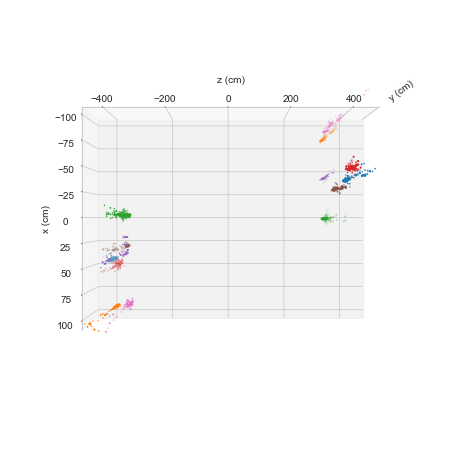

In [38]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(111, projection='3d')
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
ax1.set_zlim(zlim)
ax1.set_xlabel("x (cm)")
ax1.set_ylabel("y (cm)")
# ax1.set_zlabel("detector layer")
ax1.set_zlabel("z (cm)")
# plt.axis('off')

for x, y, z, e in zip(vx, vy, vzm, ve):
    ax1.scatter(x, y, z, s=e)

# ax1.set_title(f"Front view: reconstruction layer-clusters ({len(vx)})")
ax1.view_init(0, 180, "x")

ax1.get_yaxis().set_ticks([])
ax1.get_yaxis().set_visible(False)

# Interpretation

I got a single particle and a lot of mess in the reco data.

I only care about the reconstruction quality of this single particle.

How do I know which particle is interesting to me?

I only care about the neighbourhood of this particular trackster?

I could do "min-max" on x,y,z coordinates of the sim-trackster and construct a prism / cone / frustum of all reco-tracksters with a barycentre inside of it.

Let's have a look at an usual profile of a pion.

ValueError: in ListOffsetArray64 attempting to get 10, index out of range

(https://github.com/scikit-hep/awkward-1.0/blob/1.8.0/src/libawkward/array/ListOffsetArray.cpp#L679)

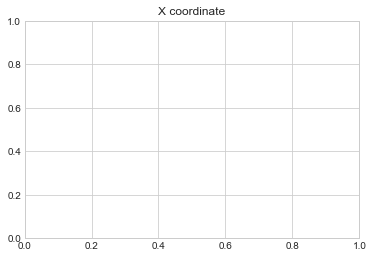

In [40]:
tid = 10

plt.title("X coordinate")
plt.hist(vx[tid], bins=20, edgecolor="lightblue")
plt.show()

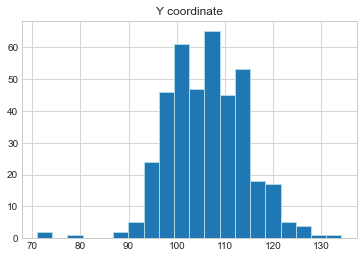

In [41]:
plt.title("Y coordinate")
plt.hist(vy[tid], bins=20, edgecolor="lightblue")
plt.show()

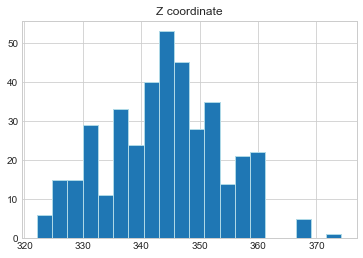

In [42]:
plt.title("Z coordinate")
plt.hist(vz[tid], bins=20, edgecolor="lightblue")
plt.show()

## Compute average X and Y per layer

In [43]:
all_z = list(sorted(set(vzm[tid])))

x_coords = {z: [] for z in all_z}
y_coords = {z: [] for z in all_z}
layer_e = {z: [] for z in all_z}

In [44]:
for x, y, z, e in zip(vx[tid], vy[tid], vzm[tid], ve[tid]):
    x_coords[z].append(x)   
    y_coords[z].append(y)
    layer_e[z].append(e)

In [45]:
x_avg = []
y_avg = []
e_sum = []

for z in all_z:
    x_avg.append(np.mean(x_coords[z]))  # should weight by energy and multiplicity here
    y_avg.append(np.mean(y_coords[z]))  # should weight by energy and multiplicity here
    e_sum.append(np.sum(layer_e[z]))

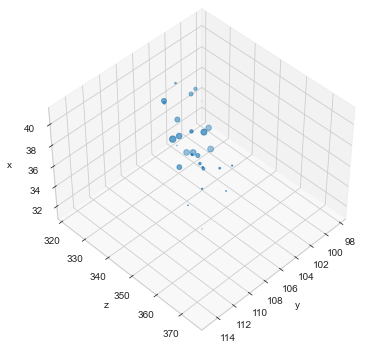

In [46]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_avg, y_avg, all_z, s=e_sum)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

ax.view_init(45, 45, "x")
plt.show()

Plot deviation from the layer mean

In [47]:
x_dev = []
y_dev = []

for i, z in enumerate(all_z):
    xm = x_avg[i]
    ym = y_avg[i]
    x_dev += [abs(xm - x) for x in x_coords[z]]
    y_dev += [abs(ym - y) for y in y_coords[z]]


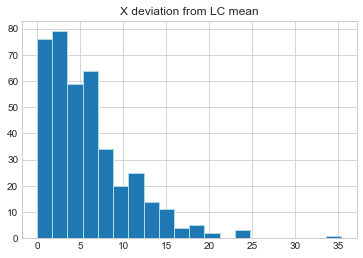

In [ ]:
plt.title("X deviation from LC mean")
plt.hist(x_dev, bins=20, edgecolor="lightblue")
plt.show()

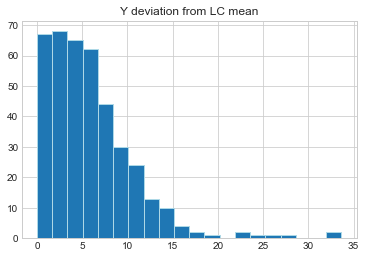

In [ ]:
plt.title("Y deviation from LC mean")
plt.hist(y_dev, bins=20, edgecolor="lightblue")
plt.show()

# Plot everything within a cylinder

In [ ]:
vx = tracksters["vertices_x"].array()[0]
vy = tracksters["vertices_y"].array()[0]
vz = tracksters["vertices_z"].array()[0]
ve = tracksters["vertices_energy"].array()[0]

bx = tracksters["barycenter_x"].array()[0]
by = tracksters["barycenter_y"].array()[0]
bz = tracksters["barycenter_z"].array()[0]

vzm = vz #[apply_map(trk, z_map) for trk in vz]

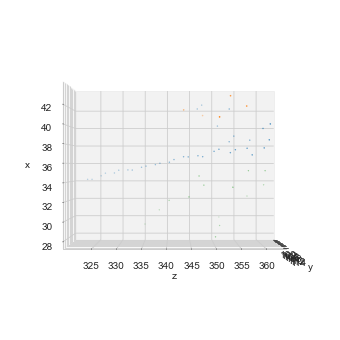

In [ ]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

for tx, ty, tzm, te, tbx, tby, tbz in zip(vx, vy, vzm, ve, bx, by, bz):
    plot = False
    # find closest layer to the barycenter
    # bl = np.argmin(np.array(all_z) < bz)

    for x, y, zm, e in zip(tx, ty, tzm, te):
        if zm not in x_coords:
            continue
        xm = np.mean(x_coords[zm])
        ym = np.mean(y_coords[zm])
        dst = np.sqrt((xm - x)**2 + (ym - y)**2)
        if dst < 10:
            plot = True
            break
    if plot:
        ax.scatter(tx, ty, tzm, s=e*2)

ax.view_init(0, 0, "x")
plt.show()

## Selection

select a trackster having at least 50% of the simtrackster energy an is above 10GeV

In [48]:
scores_above_50 = []
scores_below_50 = []
shared_dists = []
shared_dist_reco = []

for eid in range(20):
    raw_energy = tracksters["raw_energy"].array()[eid]
    sim_raw_energy = simtracksters["stsSC_raw_energy"].array()[eid]
    print(f"total tracksters: {len(raw_energy)}, above 10 GeV: {sum(raw_energy > 10)}, non-zero shared energy:")

    reco2sim_index = np.array(associations["tsCLUE3D_recoToSim_SC"].array()[eid])
    reco2sim_shared = np.array(associations["tsCLUE3D_recoToSim_SC_sharedE"].array()[eid])
    reco2sim_score = np.array(associations["tsCLUE3D_recoToSim_SC_score"].array()[eid])

    # for each reco trackster
    for recoT_idx, (sim_indexes, shared_energies, scores) in enumerate(zip(reco2sim_index, reco2sim_shared, reco2sim_score)):
        # get the shared energy with all simm tracksters
        for simT_idx, shared_energy, score in zip(sim_indexes, shared_energies, scores):
            rt_e = raw_energy[recoT_idx]
            if shared_energy > 0 and score < 0.2:
                st_e = sim_raw_energy[simT_idx]
                fr = shared_energy / st_e
                if fr > 0.5:
                    scores_above_50.append(score)
                else:
                    shared_dists.append(fr)
                    shared_dist_reco.append(shared_energy / rt_e)
                    scores_below_50.append(score)
                print(f"\tsimE: {st_e:.3f}\trecoE: {rt_e:.3f}\tshared: {shared_energy:.3f}\tscore: {score:.4f}")

total tracksters: 13, above 10 GeV: 3, non-zero shared energy:
	simE: 94.068	recoE: 1.643	shared: 1.643	score: 0.0000
	simE: 94.068	recoE: 29.129	shared: 29.129	score: 0.0000
	simE: 94.068	recoE: 4.392	shared: 4.392	score: 0.0000
	simE: 94.068	recoE: 4.786	shared: 4.786	score: 0.0000
	simE: 94.068	recoE: 1.313	shared: 1.313	score: 0.0000
	simE: 94.068	recoE: 1.369	shared: 1.369	score: 0.0000
	simE: 94.068	recoE: 0.991	shared: 0.991	score: 0.0000
	simE: 80.318	recoE: 17.301	shared: 17.301	score: 0.0000
	simE: 80.318	recoE: 4.176	shared: 4.163	score: 0.0001
	simE: 80.318	recoE: 8.403	shared: 8.403	score: 0.0000
	simE: 80.318	recoE: 16.991	shared: 16.991	score: 0.0000
	simE: 80.318	recoE: 2.798	shared: 2.798	score: 0.0000
	simE: 80.318	recoE: 2.245	shared: 2.245	score: 0.0000


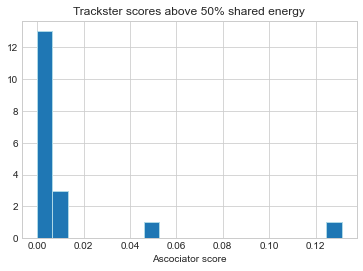

In [412]:
plt.title("Trackster scores above 50% shared energy")
plt.hist(scores_above_50, bins=20, edgecolor="lightblue")
plt.xlabel("Ascociator score")
plt.show()

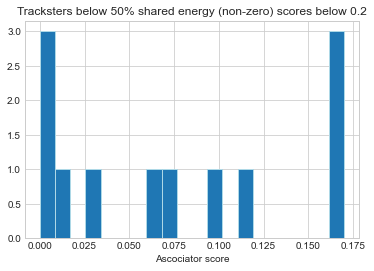

In [414]:
plt.title("Tracksters below 50% shared energy (non-zero) scores below 0.2")
plt.hist(scores_below_50, bins=20, edgecolor="lightblue")
plt.xlabel("Ascociator score")
plt.show()

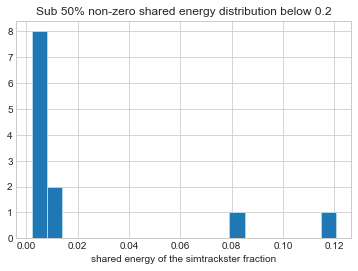

In [416]:
plt.title("Sub 50% non-zero shared energy distribution below 0.2")
plt.hist(shared_dists, bins=20, edgecolor="lightblue")
plt.xlabel("shared energy of the simtrackster fraction")
plt.show()

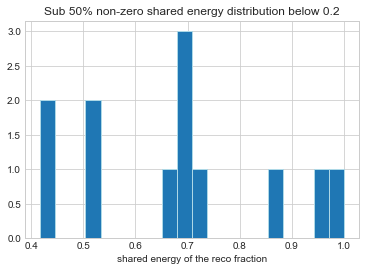

In [417]:
plt.title("Sub 50% non-zero shared energy distribution below 0.2")
plt.hist(shared_dist_reco, bins=20, edgecolor="lightblue")
plt.xlabel("shared energy of the reco fraction")
plt.show()